## 1. Setup and Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython
import librosa.display
from pathlib import Path
import kagglehub

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Set Seaborn style for better visualizations
sns.set_theme(style="whitegrid")

## 2. Load Data, List the audio files and their associated genre

In [3]:
# Download the GTZAN dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [06:27<00:00, 3.35MB/s]

Extracting files...


Path to dataset files: C:\Users\marti.MARTIN\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


In [4]:
DATASET_PATH = r"C:\Users\marti.MARTIN\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1\Data\genres_original"

In [9]:
# List all genre directories
genres = [d.name for d in Path(DATASET_PATH).iterdir() if d.is_dir()]
print(f"Genres in dataset: {genres}")

# Create a DataFrame of audio files and their genres
audio_files = []
for genre in genres:
    genre_path = Path(DATASET_PATH) / genre
    files = list(genre_path.glob("*.wav"))
    audio_files.extend([(genre, str(f)) for f in files])

# Convert to DataFrame
df = pd.DataFrame(audio_files, columns=["genre", "filepath"])
print(df.head())

# Summary of dataset
print(f"Total number of audio files: {len(df)}")

Genres in dataset: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
   genre                                           filepath
0  blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
1  blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
2  blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
3  blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
4  blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
Total number of audio files: 1000


After exploring the Kaggle discussions, it appears that the file jazz.00054 is not playable and the file reggae.00086 is defective after 7 sec.

So it's preferable to just delete them from the dataframe:

In [47]:
# Define the filenames of the defective files
defective_files = ['jazz.00054', 'reggae.00086']

# Filter out the defective files from the dataframe
df = df[~df['filepath'].str.contains('|'.join(defective_files))]

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Print the updated dataframe
print("Updated dataframe after removing defective files:")
print(df)

Updated dataframe after removing defective files:
     genre                                           filepath
0    blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
1    blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
2    blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
3    blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
4    blues  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
..     ...                                                ...
993   rock  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
994   rock  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
995   rock  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
996   rock  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...
997   rock  C:\Users\marti.MARTIN\.cache\kagglehub\dataset...

[998 rows x 2 columns]


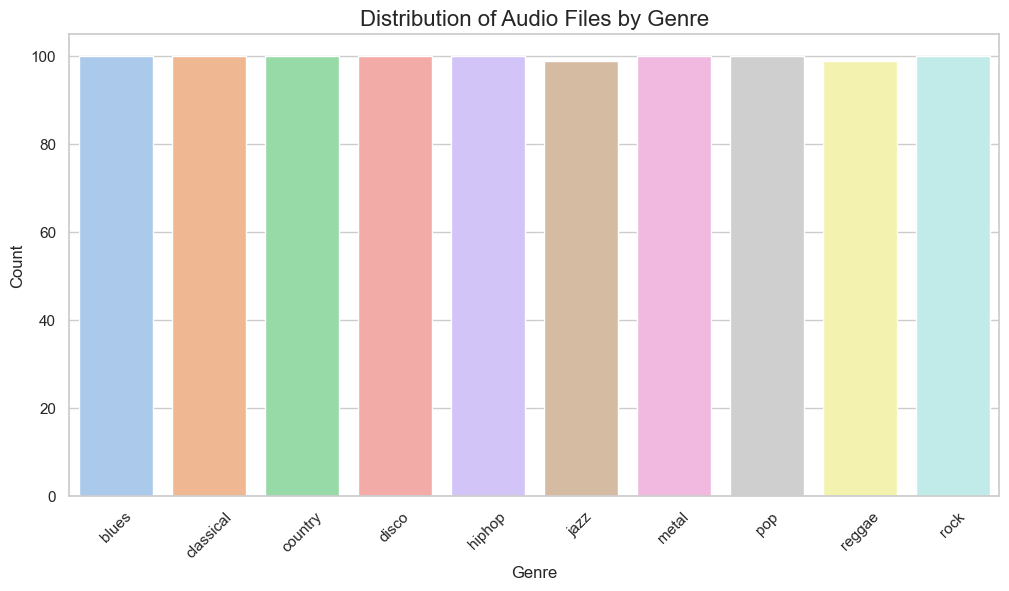

In [46]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="genre", hue="genre", palette="pastel", order=genres, dodge=False, legend=False)
plt.title("Distribution of Audio Files by Genre", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 3. Audio Analysis
### 3.1. Waveform and Spectrogram
Sound is represented in the form of an audio signal having parameters such as frequency, bandwidth, decibel, etc. A typical audio signal can be expressed as a function of Amplitude and Time shown below:

<img src="../images/audio-time-frequency.jpg" alt="Audio Time Frequency" width="600">

We use Librosa to load an audio file and inspect its waveform, sampling rate, and duration.

Sample Rate: 22050 Hz
Duration: 30.01 seconds
Number of Samples: 661794


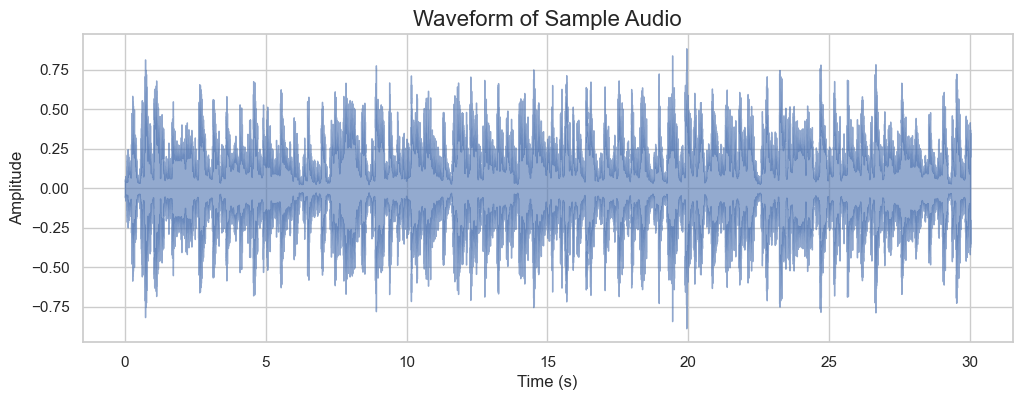

In [53]:
# Load a sample audio file
sample_file = df.loc[0, "filepath"]
y, sr = librosa.load(sample_file, sr=None)  # sr=None retains original sampling rate

# Display basic information
print(f"Sample Rate: {sr} Hz")
print(f"Duration: {len(y) / sr:.2f} seconds")
print(f"Number of Samples: {len(y)}")

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform of Sample Audio", fontsize=16)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.show()

IPython.display.Audio lets you play audio directly in a jupyter notebook:

In [57]:
IPython.display.Audio(y, rate=sr)

We analyze the audio in the frequency domain using a spectrogram.  
A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 200 Hz vs 1000 Hz, but one can also see how energy levels vary over time.

A spectrogram is usually depicted as a heat map, i.e., as an image with the intensity shown by varying the color or brightness.

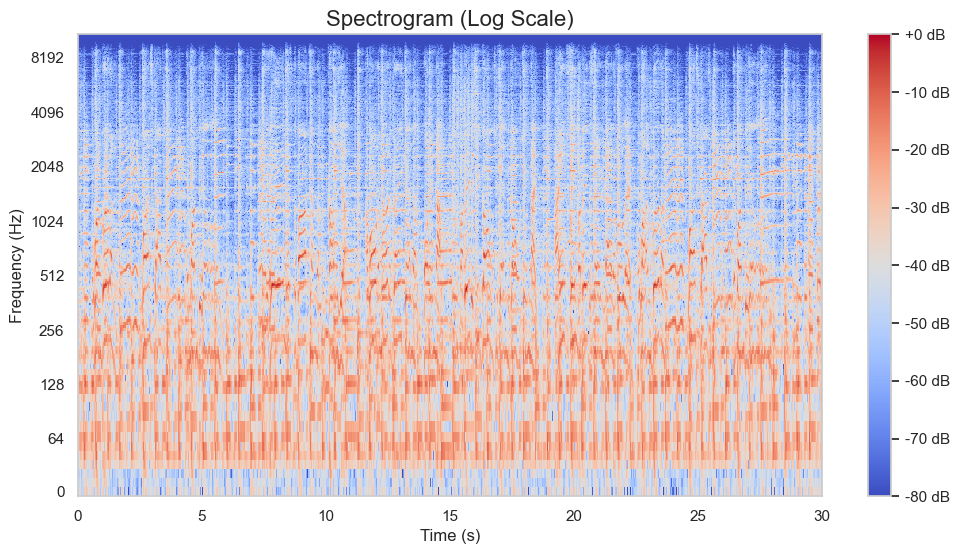

In [19]:
# Compute the short-time Fourier transform (STFT)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log", cmap="coolwarm")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Log Scale)", fontsize=16)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.show()

Let's do it for the first track of each genre:

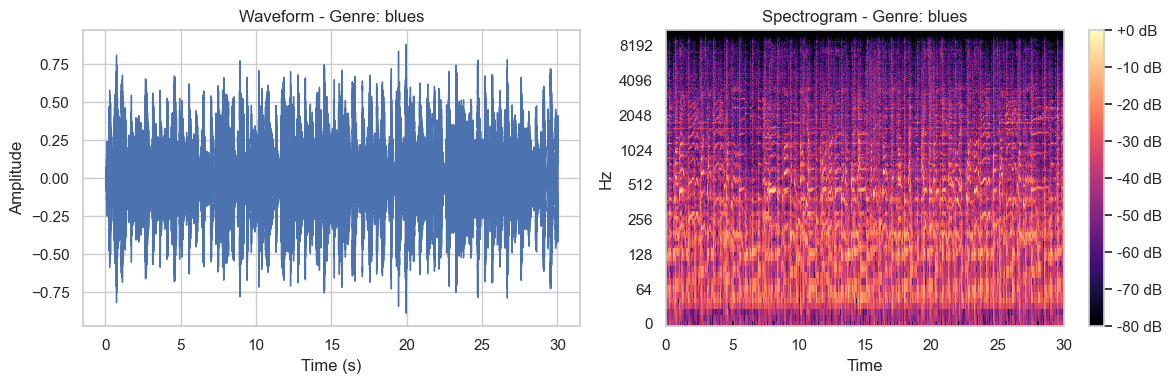

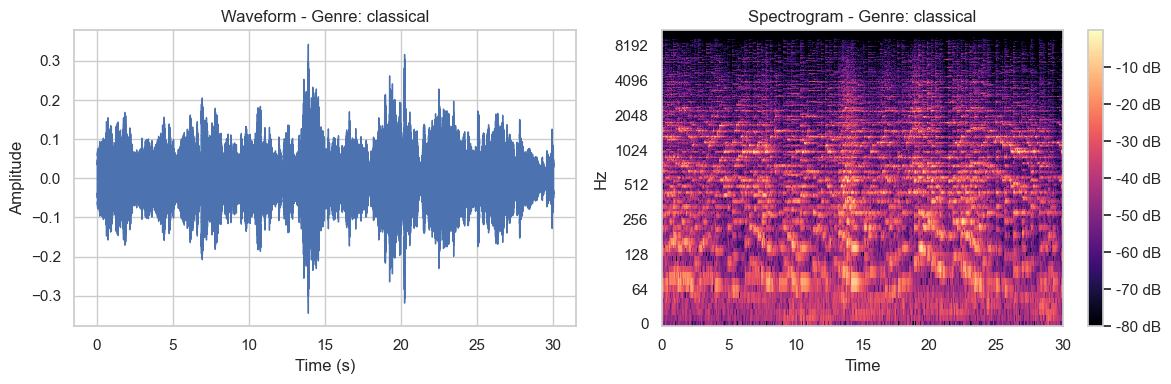

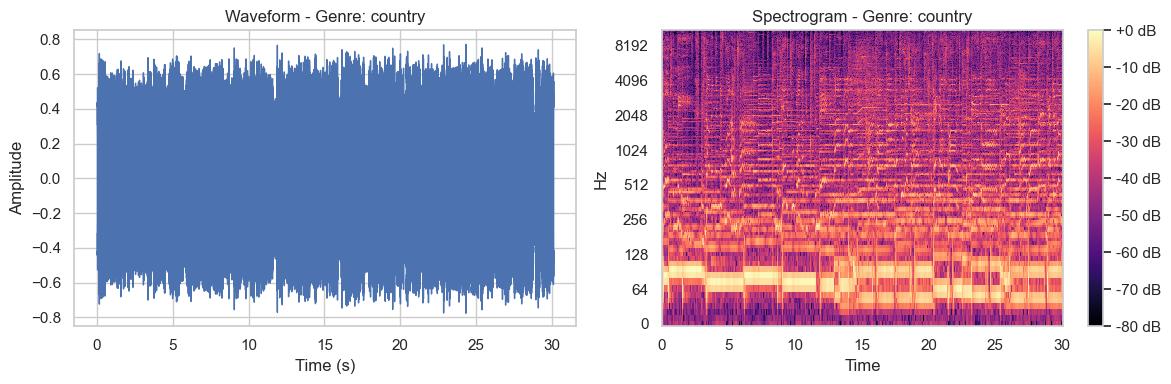

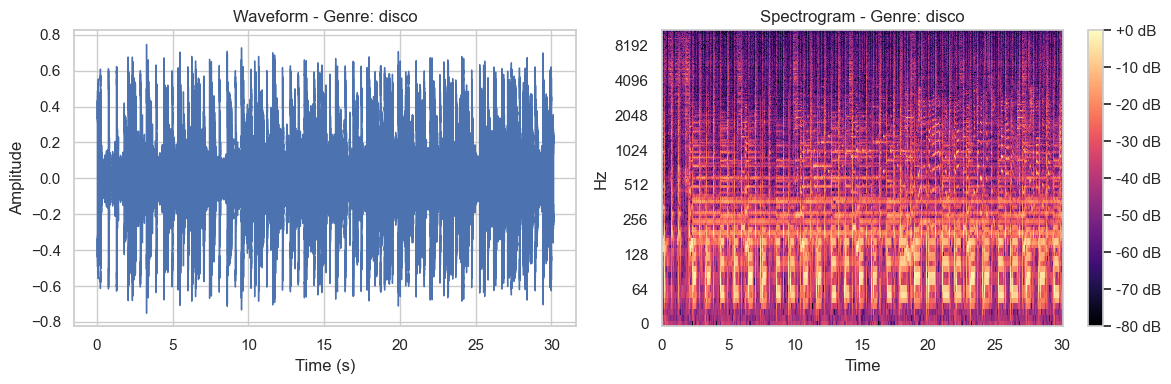

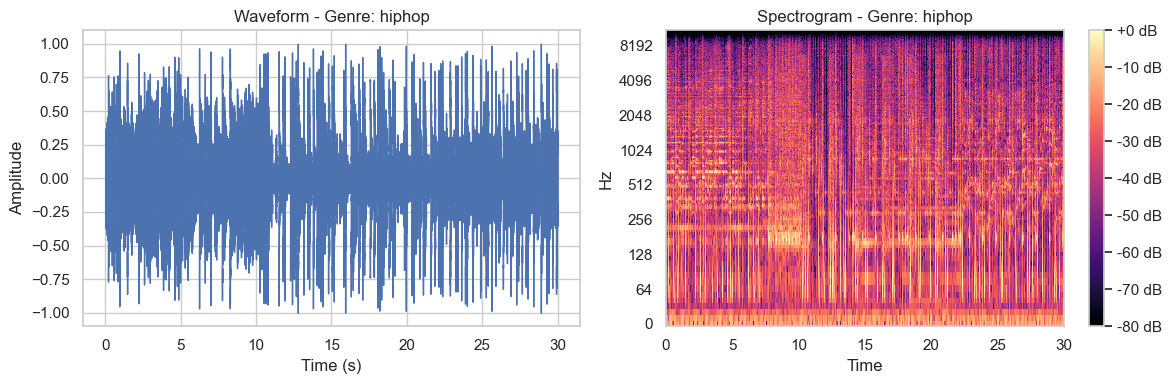

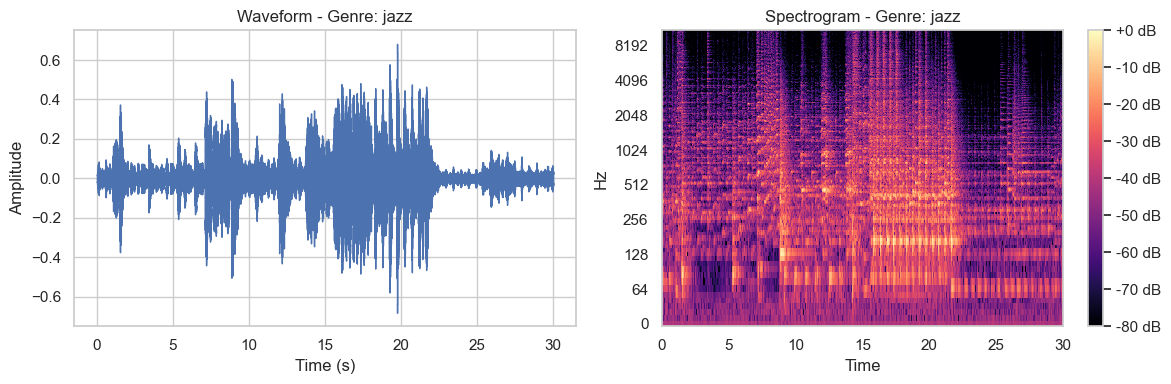

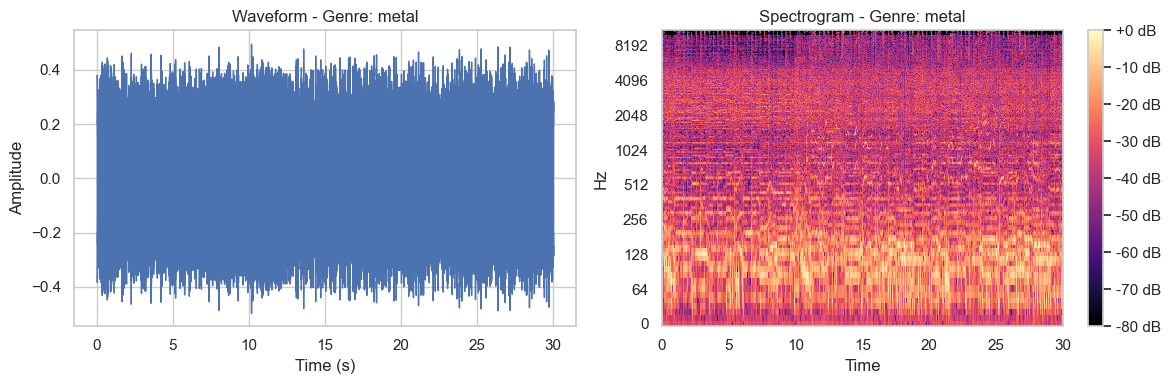

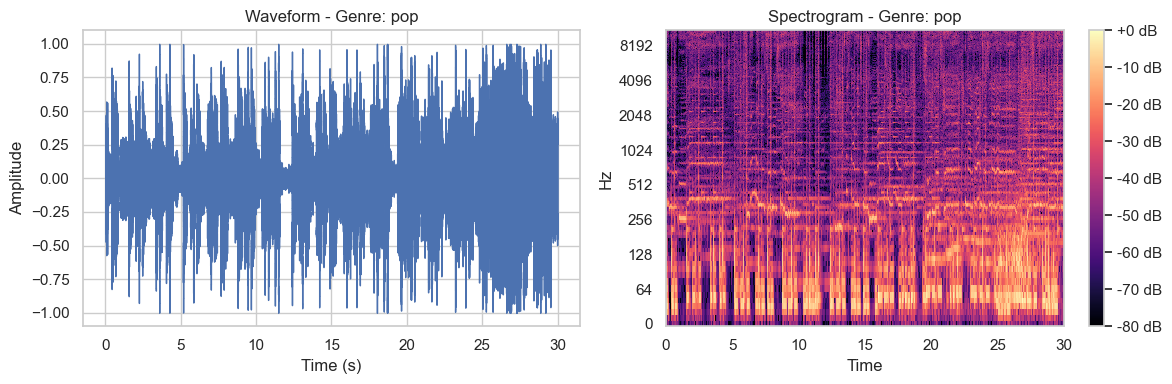

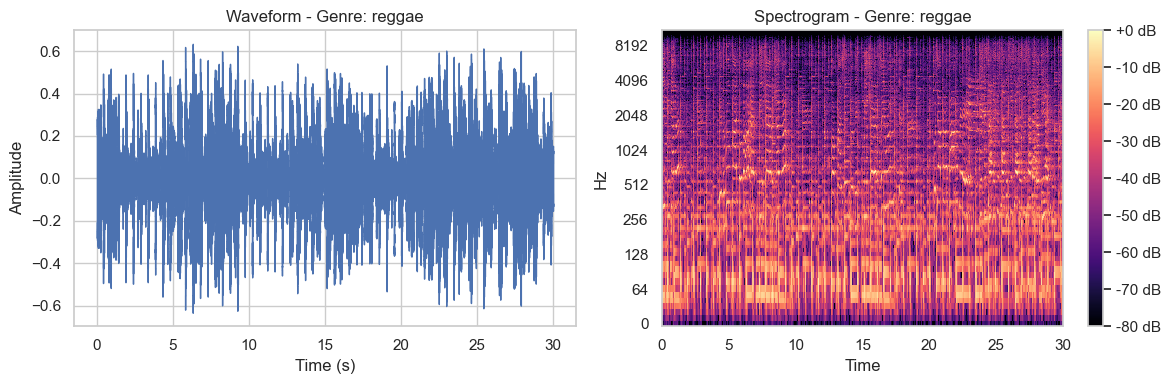

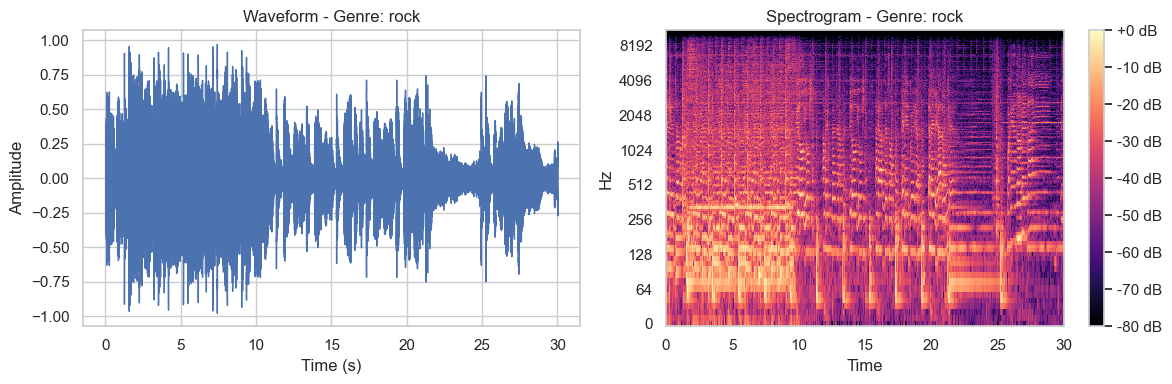

In [ ]:
# Group dataframe by genre and take the first file from each genre
df_first_per_genre = df.groupby('genre').first().reset_index()

# Iterate through each genre's first audio file
for _, row in df_first_per_genre.iterrows():
    filepath = row['filepath']
    genre = row['genre']
    
    # Load the audio file
    y, sr = librosa.load(filepath, sr=None)
    
    # Plot the waveform and spectrogram
    plt.figure(figsize=(12, 4))
    
    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - Genre: {genre}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram - Genre: {genre}')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

With Librosa, it's possible to extract a bunch of other audio features, particularly spectral features (frequency-based features), which are obtained by converting the time-based signal into the frequency domain using the Fourier Transform (fundamental frequency, frequency components, spectral centroid, spectral flux, spectral density, spectral roll-off, MFCC, etc...).

Among them, **Mel-frequency cepstral coefficients (MFCCs)** are crucial for analyzing audio signals, especially in music classification. I will focus on these ones for the rest of this project.

### 3.2. Extract and Visualize MFCCs
MFCCs are a representation of the short-term power spectrum of an audio signal, based on a linear cosine transform of a log power spectrum on a **Mel scale**. They are widely used in speech and audio processing, particularly for tasks like **music genre classification**, **speech recognition**, and **emotion detection**. MFCCs are valued for their ability to represent the perceptually relevant aspects of sound.

**How Are MFCCs Computed?**  

**1. Frame the Audio Signal:**  
The audio signal is split into short overlapping frames to analyze the signal locally (usually 20–40 ms per frame).

**2. Apply the Fourier Transform:**  
Converts the time-domain signal into the frequency domain to understand the energy distribution.

**3. Map Frequencies to the Mel Scale:**  
The Mel scale mimics human hearing, with more resolution at lower frequencies and less at higher frequencies.

**4. Take the Logarithm:**  
Converts the power spectrum into a log scale to better reflect human auditory perception.

**5. Apply the Discrete Cosine Transform (DCT):**  
Compresses the Mel log spectrum into a smaller number of coefficients, capturing the most significant features of the audio.

**Key Properties of MFCCs**
- **Dimension:** Typically, the first 13 or 20 coefficients are used, as they carry most of the relevant information.
- **Low-Frequency Emphasis:** MFCCs focus more on low-frequency energy, which is essential for music and speech understanding.
- **Noise Robustness:** They provide a compact representation, reducing the influence of background noise.

With librosa, we can extract quite easily:

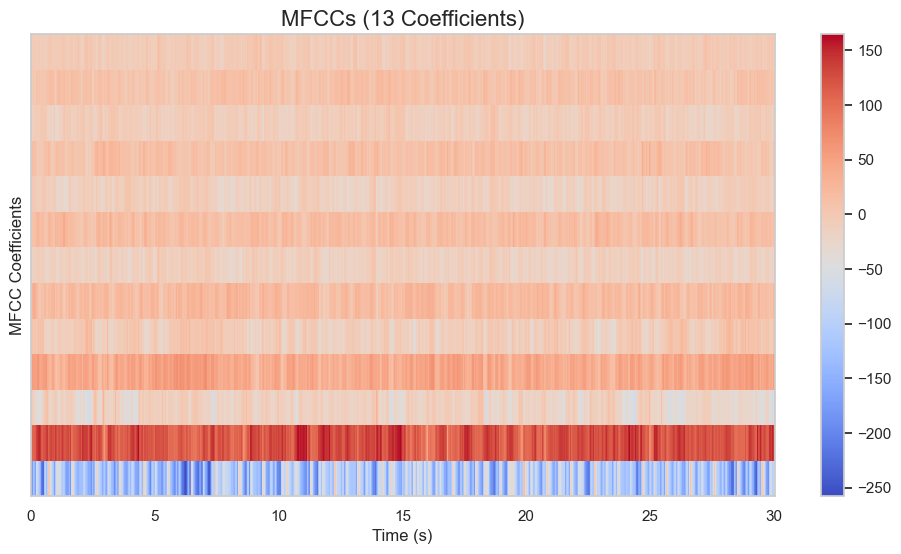

In [27]:
# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(12, 6))
librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="coolwarm")
plt.colorbar()
plt.title("MFCCs (13 Coefficients)", fontsize=16)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("MFCC Coefficients", fontsize=12)
plt.show()

**How to interpret the MFCCs Heatmap?** 

**1. Intensity (color scale)**
- A higher intensity (bright spots) means the sound has more energy or emphasis in the corresponding frequency range during that timeframe.
- Lower intensity indicates less emphasis or quieter components.

**2. Temporal evolution (X-axis)**
- Represents the progression of the audio over time, usually broken down into small windows (e.g., 20-50 ms). Each column corresponds to a time slice where MFCCs were calculated.
- Observe how patterns change over time (moving left to right).
- Repeated patterns in the heatmap may indicate rhythmic consistency (e.g., drums in electronic or hip-hop).
- Sudden shifts in intensity reflect transitions, like a chorus, verse, or drop.

**3. MFCC coefficients (Y-axis)**
- Each row corresponds to a specific MFCC coefficient.
- The lower coefficients (at the bottom e.g., MFCC_1, MFCC_2) represent overall energy/general frequency features like pitch or loudness.  
Use Case: Useful for distinguishing between genres with different tonal foundations, such as classical (lower pitch focus) vs. metal (higher energy).
- Mid-level coefficients (MFCC_4-9) describe the rhythmic and harmonic qualities of the audio.  
Use Case: Crucial for genres like hip-hop (strong rhythms) or jazz (complex harmonic content).
- The higher coefficients (e.g., MFCC_10–13) capture finer details, such as timbral textures or high-frequency variations.

#### Comparing MFCC Features Across Genres

In [36]:
# Function to load an audio file and extract MFCCs
def extract_mfcc(file_path, sr=22050, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

# Extract MFCCs for one sample from each genre
sample_files = {genre: df[df["genre"] == genre]["filepath"].iloc[99] for genre in genres}

mfccs_by_genre = {genre: extract_mfcc(path) for genre, path in sample_files.items()}

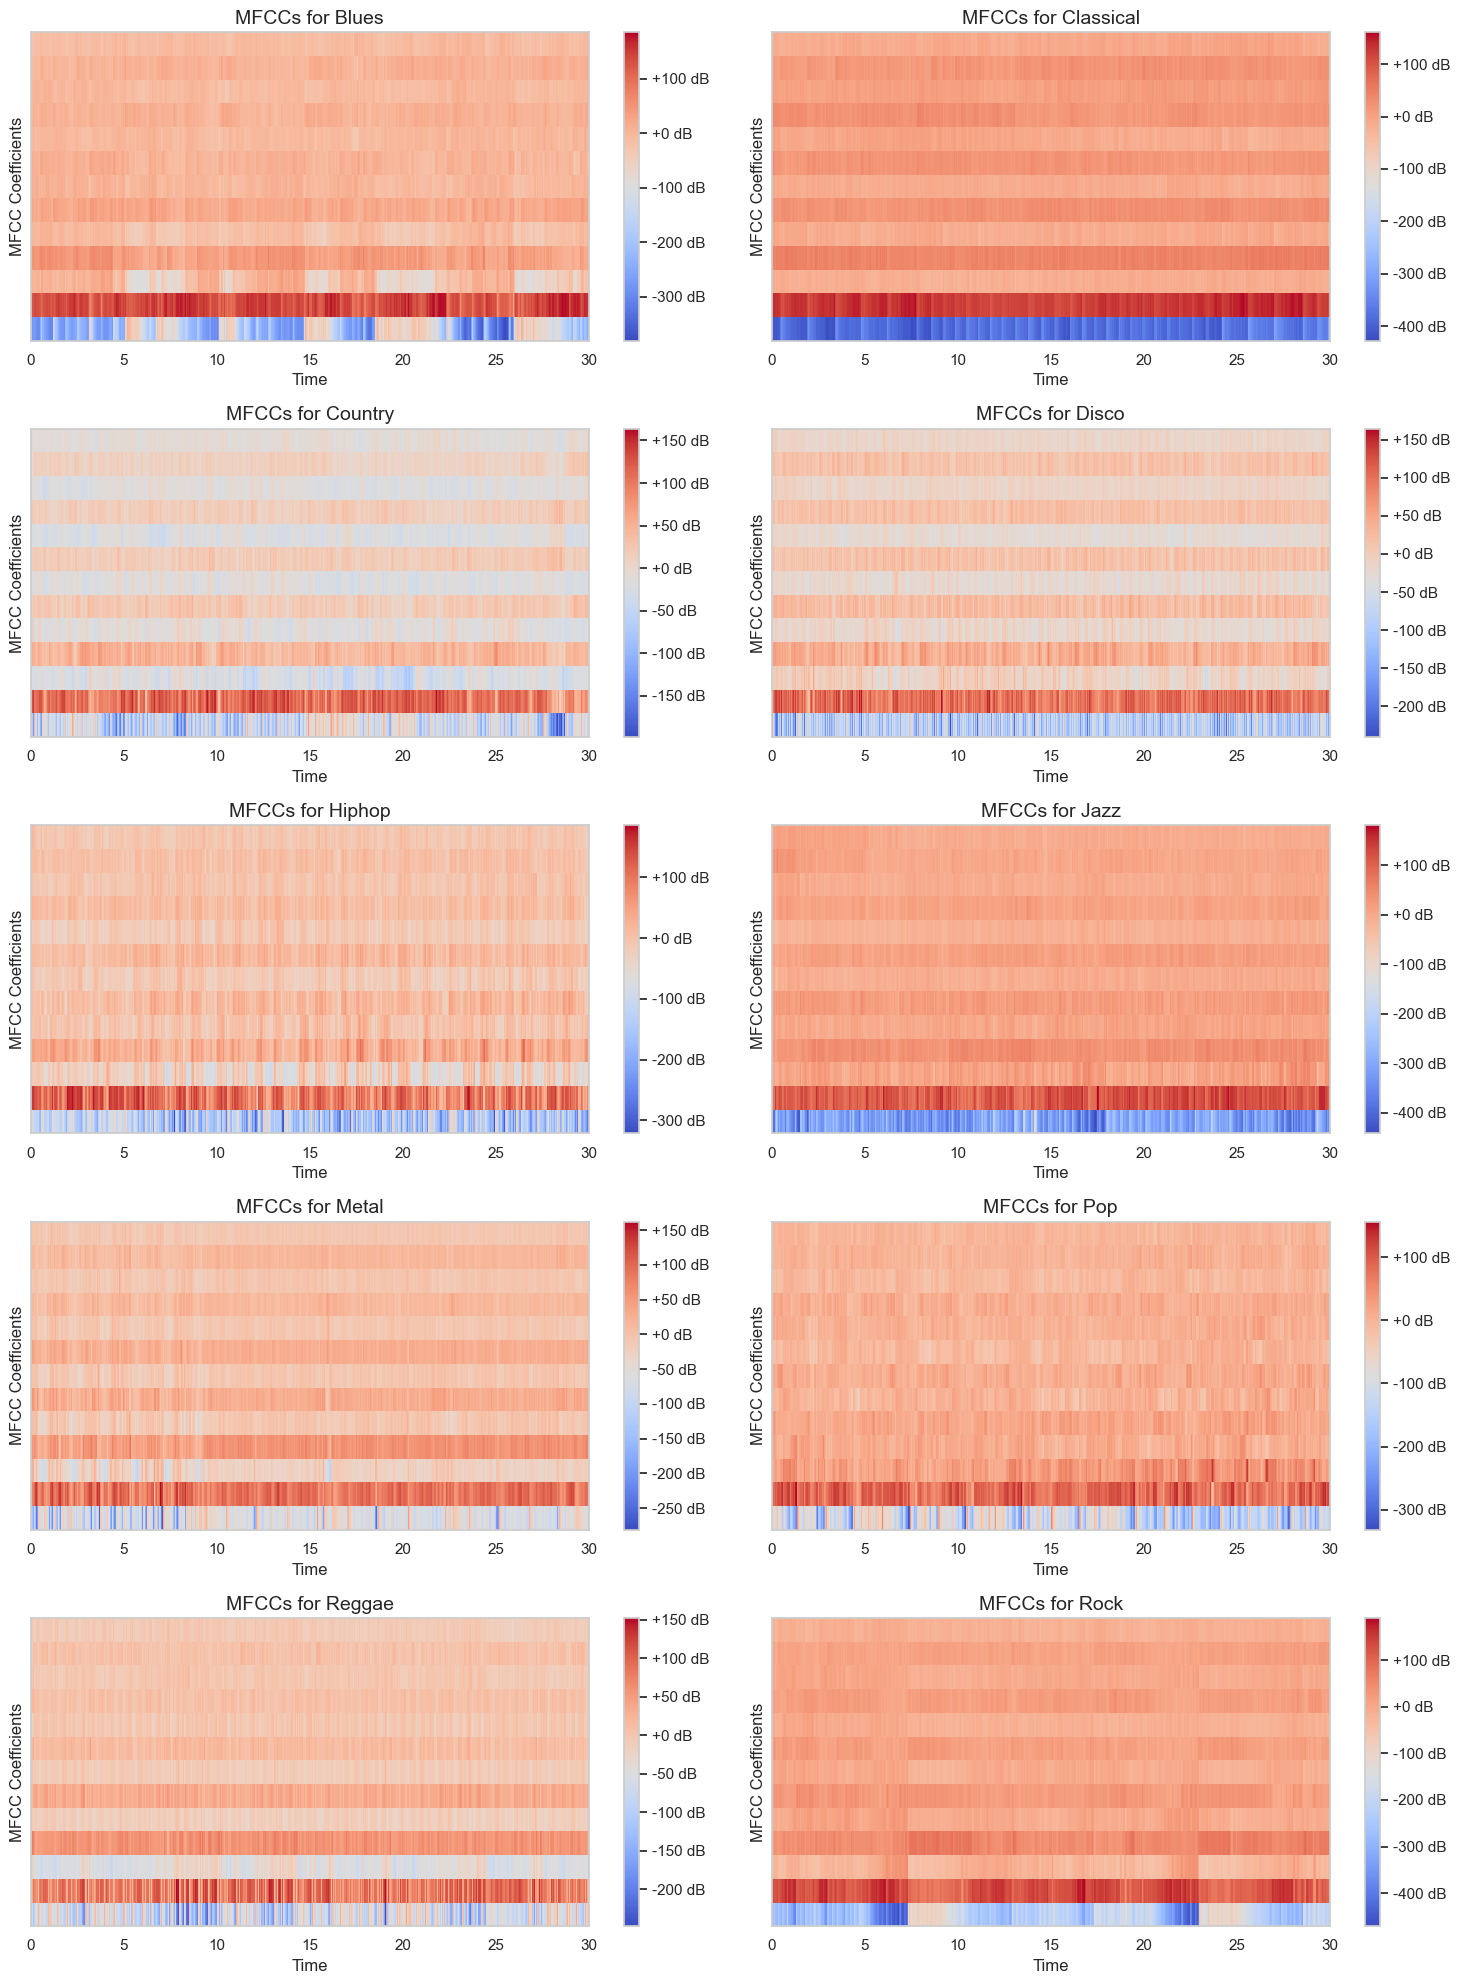

In [39]:
# Plot MFCCs for each genre
plt.figure(figsize=(15, 20))

for i, (genre, mfcc) in enumerate(mfccs_by_genre.items()):
    plt.subplot(len(genres) // 2, 2, i + 1)
    librosa.display.specshow(mfcc, x_axis="time", cmap="coolwarm")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"MFCCs for {genre.capitalize()}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

Looking at these MFCC heatmaps across different music genres reveals several patterns and characteristics in how audio features vary across musical styles. Let's break down some **key observations**:

**Temporal Structure:**
Classical music shows the most organized and structured patterns, with clear horizontal bands that likely correspond to its formal compositional structure and consistent orchestration. This contrasts sharply with genres like Metal and Rock, which display more irregular and intense patterns, reflecting their dynamic range and complexity.

**Low-Frequency Content:**
The bottom portions of most graphs (particularly visible in Blues, Metal, and Rock) show intense red and blue alternations, indicating strong variations in bass frequencies. This is especially prominent in genres that rely heavily on bass instruments and drums. Classical music shows more consistent patterns in these lower coefficients, suggesting more controlled use of lower frequencies.

**Genre-Specific Characteristics:**
- Jazz exhibits complex, intricate patterns with frequent variations, reflecting its improvisational nature and rich harmonic content.
- Hip-hop shows regular, blocky patterns, likely corresponding to its beat-driven, loop-based structure.
- Disco demonstrates very regular, repeating patterns, consistent with its steady rhythmic nature and structured arrangements.
- Reggae displays distinctive regular striping patterns, particularly in the mid-range coefficients, probably reflecting its characteristic off-beat rhythms and specific instrumental techniques.

**Dynamic Range:**
The color intensity variations (from deep blue to bright red) indicate different dynamic ranges across genres:
- Metal and Rock show the widest dynamic range, with extreme contrasts between quieter and louder sections.
- Classical music also shows significant dynamic variation, but in a more controlled and gradual manner.
- Pop music shows more consistent, moderate intensity levels, reflecting modern production techniques that compress dynamic range.

**Temporal Consistency:**
Country and Blues show interesting combinations of regular patterns interrupted by more variable sections, likely corresponding to transitions between verses, choruses, and instrumental breaks. This creates a distinctive visual fingerprint that differs from both the high regularity of Disco and the high variability of Jazz.

To quantify differences, calculate the mean MFCC values over time for each genre and compare them:

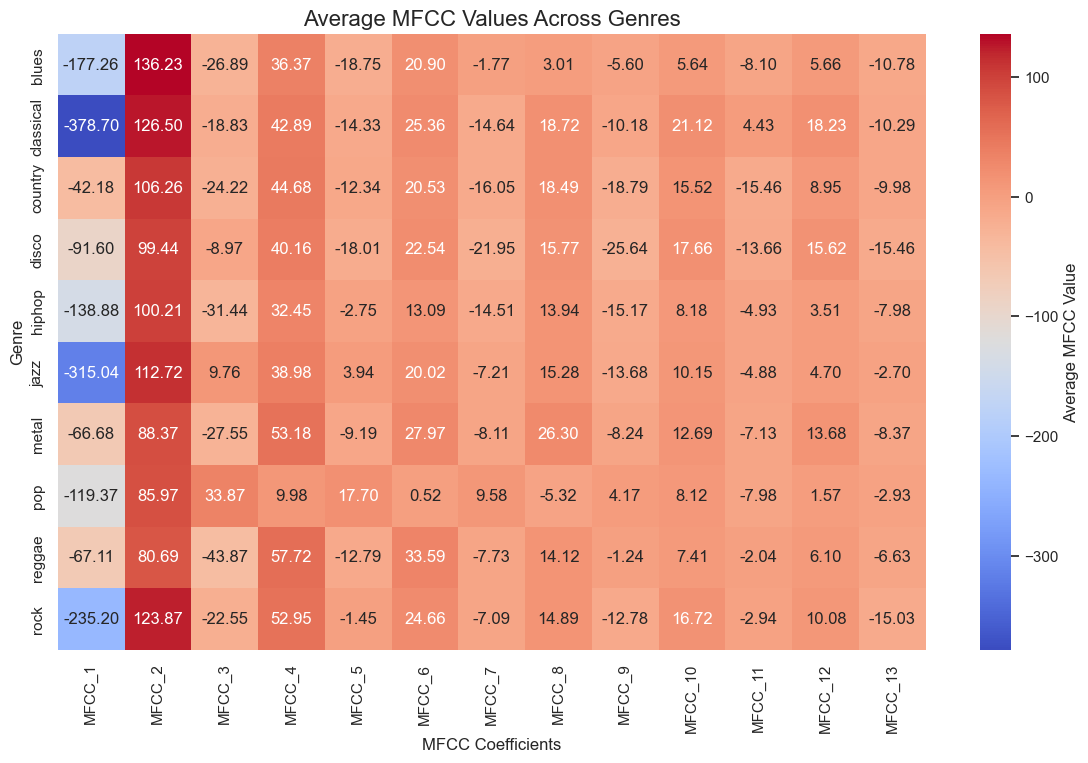

In [40]:
# Compute mean MFCC values for each genre
mean_mfccs = {genre: mfcc.mean(axis=1) for genre, mfcc in mfccs_by_genre.items()}

# Create a DataFrame for easier analysis
mean_mfcc_df = pd.DataFrame(mean_mfccs).T
mean_mfcc_df.columns = [f"MFCC_{i+1}" for i in range(mean_mfcc_df.shape[1])]
mean_mfcc_df.index.name = "Genre"

# Plot the average MFCCs
plt.figure(figsize=(14, 8))
sns.heatmap(mean_mfcc_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Average MFCC Value"})
plt.title("Average MFCC Values Across Genres", fontsize=16)
plt.xlabel("MFCC Coefficients", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.show()

This heatmap of average MFCC values across different music genres reveals some insights about the acoustic characteristics that define each genre:

First, looking at MFCC_1 (first column), we see very negative values for classical, rock, jazz, and blues. This coefficient typically represents overall energy distribution, and these strongly negative values suggest these genres have more complex spectral distributions, likely due to their wider instrumental variety and dynamic range. In contrast, country and reggae show more moderate negative values, indicating a more balanced spectral distribution.

MFCC_2 shows consistently high positive values across all genres, with blues, classical, and rock having the highest values (>120). This coefficient often relates to the balance between low and high frequencies. The high positive values suggest all genres maintain strong foundational bass frequencies, but particularly in blues, classical, and rock music.

Moving to the mid-range coefficients (MFCC_4 through MFCC_8), we can observe some genre-specific characteristics:
- Metal and reggae show notably high values in MFCC_4 (>50), suggesting stronger presence in certain mid-frequency bands, possibly related to guitar distortion in metal and the distinctive "skank" guitar rhythm in reggae.
- Pop music shows more moderate values across these coefficients, reflecting its typically balanced, radio-friendly production style.
- Classical music demonstrates distinct patterns in these mid-range coefficients, likely capturing its unique orchestral timbre.

The higher-order coefficients (MFCC_9 through MFCC_13) show more subtle variations, but some patterns emerge:
- Disco shows relatively high values in MFCC_12, possibly capturing its characteristic high-frequency elements like hi-hats and synthesizers.
- Classical and rock music maintain relatively strong values even in these higher coefficients, suggesting more complex harmonic content.
- Hip-hop shows more moderate values, reflecting its often more controlled and produced sound.

Looking at the overall pattern, we can see that certain genres cluster together in their MFCC profiles. For example, rock and blues share similar patterns across many coefficients, which makes sense given their historical and musical relationships. Similarly, pop and disco show some commonalities, particularly in their mid-range coefficients, reflecting their shared focus on dance-friendly, produced sounds.

## 4. Insights and Conclusions
- Except two defective files, the dataset is balanced across genres, with 100 audio files per genre and 99 for jazz and reggae.
- Librosa allows us to analyze audio signals in both the time and frequency domains.
- Diverse Feature Distributions: The features extracted from the audio files show diverse distributions, highlighting the complexity and variability in music genres.
- MFCCs are a powerful tool for distinguishing between audio signals. These patterns effectively demonstrate how MFCCs can capture the unique spectral characteristics that make each genre distinctive, while also revealing unexpected similarities between seemingly different styles. The visualizations provide valuable insights into both the musical structure and production characteristics of different genres.

By visualizing and analyzing MFCC features, we can uncover meaningful differences across music genres, which is critical for building an effective music genre classification system.


The next part in [`data_preparation.ipynb`](data_preparation.ipynb) will be to preprocess these audio files to have enough prepared data for a neural network input. For this, I will extract MFCCs for a 3-sec chunk of every audio files with their corresponding genre (the target) and store it in an appropriate file format.